# NOAA 自然重建数据的处理

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import os
from hydra import compose, initialize
from mksci_font import config_font

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

config_font({"font.size": 9})

## 筛选数据

In [3]:
from past1000.calibration import load_nat_data

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=1000,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 7 files matching the pattern.


,north-china-precip2010,shanxi2015precip,tan2011precip-noaa,xu2023-asm,qinling2016precip,north-china-temp-precip2011,hexi2019scpdsi
year,,,,,,,
2009,NaN,NaN,NaN,-1.466621,-0.568723,NaN,-0.809462
2010,NaN,NaN,NaN,1.170888,0.307108,NaN,0.515620
2011,NaN,NaN,NaN,1.248765,NaN,NaN,-1.255668
2012,NaN,NaN,NaN,-1.204711,NaN,NaN,NaN
2013,NaN,NaN,NaN,0.140132,NaN,NaN,NaN


最佳分布：Student-t（t）表现最佳：

- 最低sumsquare_error（1.003480），表明直方图拟合最好。
- 较低的AIC（495.670695）和BIC（507.652580），优于lognorm和gamma。
- 最低ks_statistic（0.040494）和最高ks_pvalue（0.5134515），CDF拟合极佳。

次佳分布：lognorm：
- sumsquare_error（1.010543）、AIC（500.570491）、BIC（512.552375）略逊于t。
- ks_statistic（0.040599）和ks_pvalue（0.5101007）与t接近，拟合良好。

In [4]:
from past1000.data import check_distribution
from matplotlib import pyplot as plt


check_distribution(datasets)

2025-07-04 09:32:59.067 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=1.047874)
2025-07-04 09:32:59.073 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=1.377051)
2025-07-04 09:32:59.170 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.49392)
2025-07-04 09:32:59.200 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=1.05305)
2025-07-04 09:32:59.214 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted exponpow distribution with error=1.06784)
2025-07-04 09:32:59.241 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=2.994103)
2025-07-04 09:32:59.260 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=2.660393)
2025-07-04 09:32:59.263 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted nor

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue,best_dist
north-china-precip2010,1.00348,495.670695,507.65258,inf,0.040494,0.513451,t
shanxi2015precip,2.819712,460.004579,468.652985,inf,0.086142,0.265646,t
tan2011precip-noaa,6.759237,352.906872,357.950449,inf,0.057617,0.902688,norm
xu2023-asm,0.651503,460.106665,468.215544,inf,0.021442,0.987321,norm
qinling2016precip,0.461476,512.808013,525.688271,inf,0.030158,0.697089,t
north-china-temp-precip2011,0.492981,584.286043,597.121607,inf,0.026258,0.846268,t
hexi2019scpdsi,0.23743,512.520476,527.279528,inf,0.018852,0.857804,t


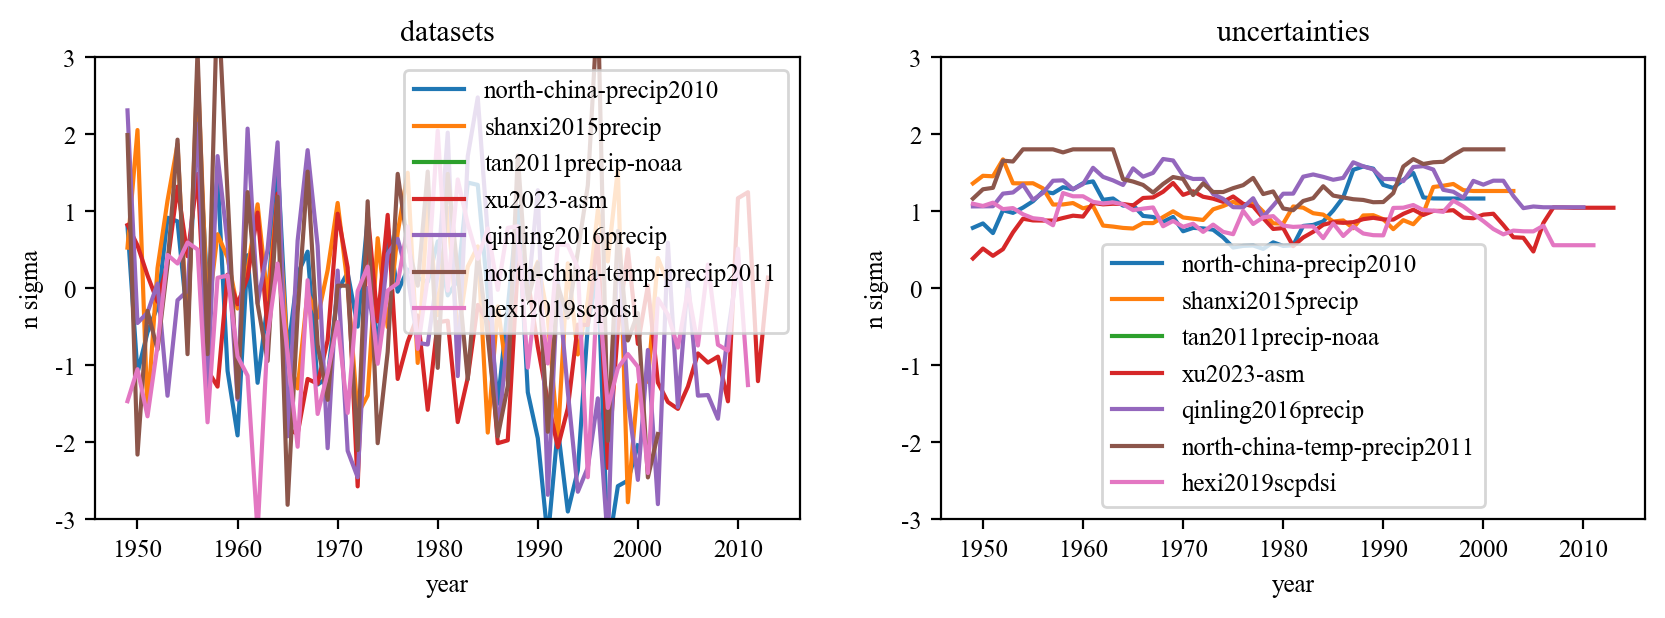

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
datasets.loc[1949:].plot(ax=ax[0])
uncertainties.loc[1949:].plot(ax=ax[1])
ax[0].set_title("datasets")
ax[1].set_title("uncertainties")
for a in ax:
    a.set_ylabel("n sigma")
    a.set_ylim(-3, 3)
plt.show();

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


array([[<Axes: title={'center': 'true_drought'}>,
        <Axes: title={'center': 'true_drought'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

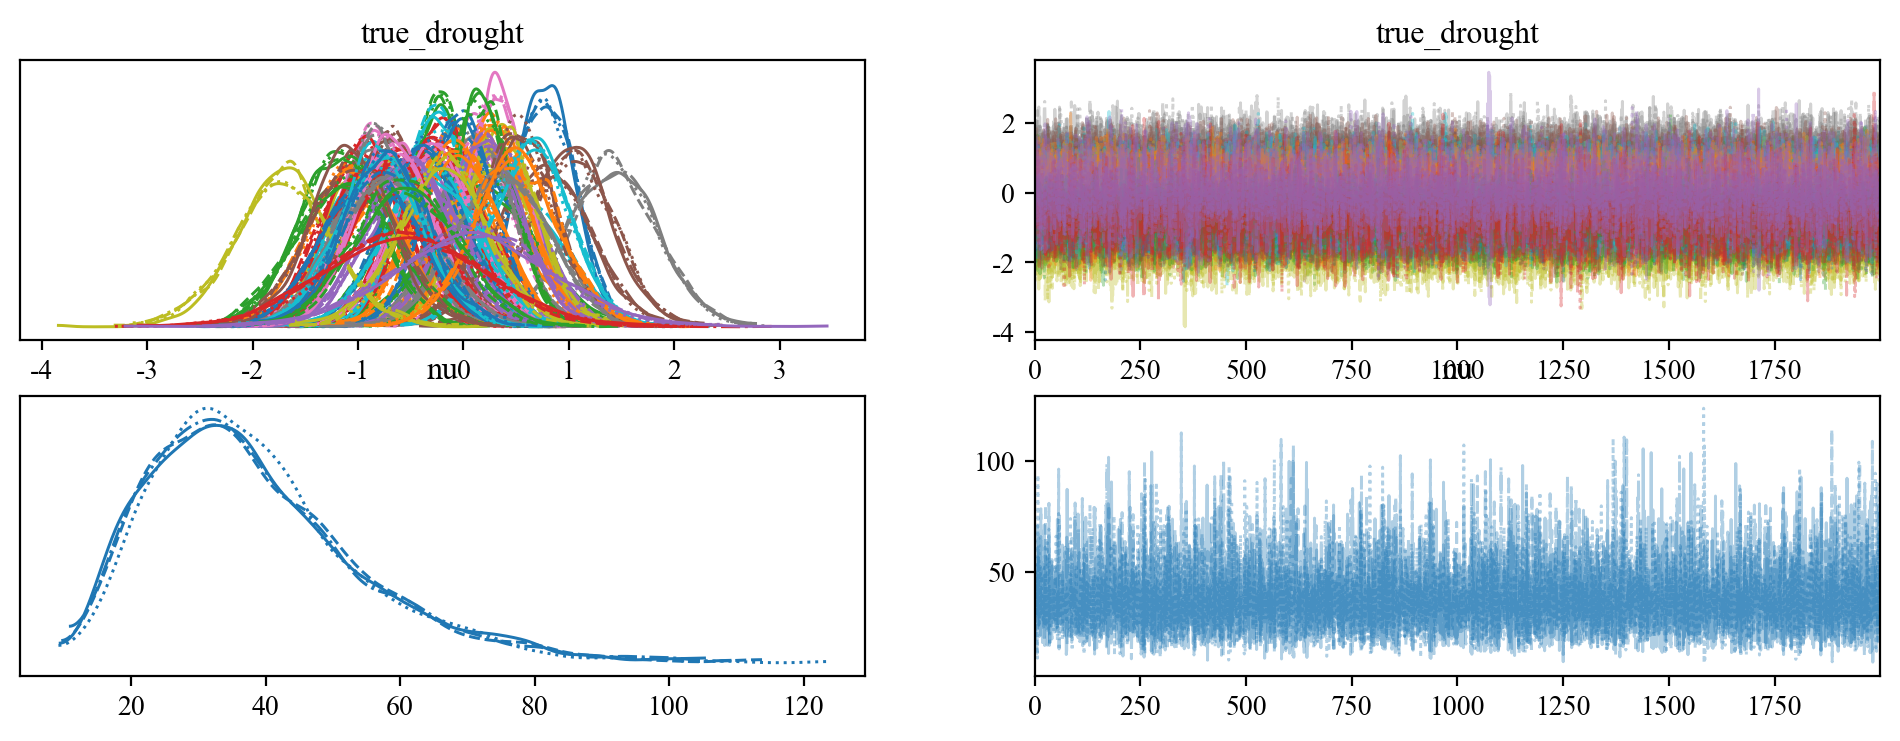

In [6]:
from past1000.mc import combine_reconstructions
import arviz as az

combined, trace = combine_reconstructions(
    datasets.loc[1949:],
    uncertainties.loc[1949:],
    standardize=False,
)

az.plot_trace(trace, var_names=["true_drought", "nu"])

把历史数据中的各个站点进行聚合的方法我尝试了：

1. 众数
2. 平均数+取整

效果目前看起来都差不多

1960年，Cohen 等人提出使用Kappa 值！作力判断评价一致性程度指标，目前在医疗等行业得到广泛的
应用，已经成为判断一致性？和信用度评价的一种常用统计学重要指标。Kappa 值的可能取值范围是从-1到
1,Kappa 值小于0.7时表示测量系统不合格，在0.7~0.9 时表示测量系统可接受，大于等于0.9时表示测量系统良好（[参考知乎](https://www.zhihu.com/question/28884747?sort=created)）。

$$ k=\frac{P_{\mathrm{o}}-p_{\mathrm{e}}}{1-p_{\mathrm{e}}} $$

其中Po为编码一致的样本比例，Pe为编码不一致样本计算出的偶然预期一致性比例。其中Pe的计算为：

$$ p_{\mathrm{e}}=\frac{1}{n^2} \sum_{m=1}^4 f_{i m} \cdot f_{j m} $$

> [!info]
> 关于linear还是quadratic weighted kappa的选择，取决于你的数据集中不同class之间差异的意义。比如对于眼底图像识别的数据，class=0为健康，class=4为疾病晚期非常严重，所以对于把class=0预测成4的行为所造成的惩罚应该远远大于把class=0预测成class=1的行为，使用quadratic的话0->4所造成的惩罚就等于16倍的0->1的惩罚。

具体实现上，可以使用 [sklearn 的 `cohen_kappa_score` 函数](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html)，其中 weights 参数可以设置为 'linear' 或 'quadratic'。

<Axes: title={'center': "Kappa: 0.51, Kendall's Tau: 0.48**"}, xlabel='Predicted label', ylabel='True label'>

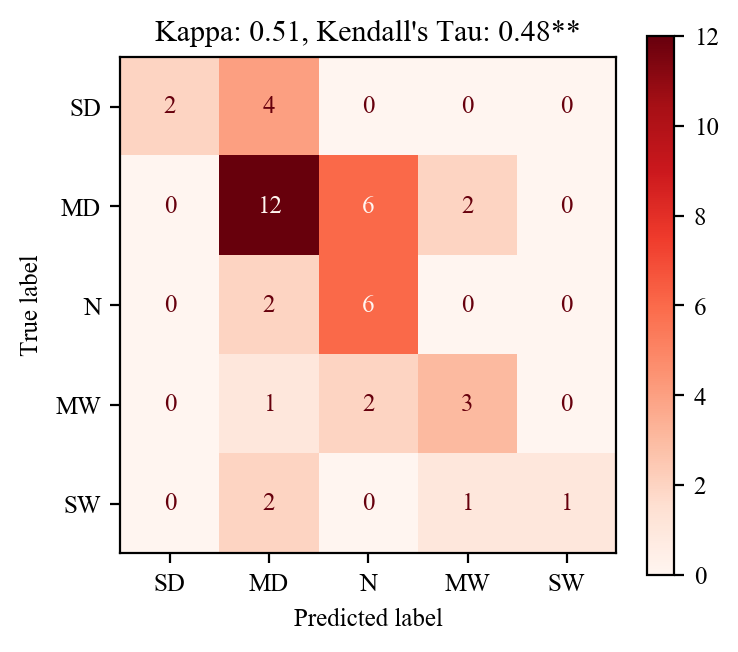

In [7]:
from past1000.data import HistoricalRecords
from past1000.filters import classify
from past1000.utils.plot import plot_confusion_matrix

# 历史记录
stage4 = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
).stage4
y_true = stage4.mode(axis=1)[0]

# 对比历史记录和分类结果
classification = classify(combined["mean"]).loc[1949:2010]
y_pred = classification.loc[1949:2010]

plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    dropna=True,
)

(1) Cohen's Kappa (κ) = 0.60

Landis & Koch (1977) 标准：

1. 0.61–0.80：显著一致性（Substantial Agreement）
2. 0.60 处于"中等"（Moderate）和"显著"（Substantial）的边界，但更接近"显著"。

实际意义：模型预测与真实标签的一致性较好，已超过随机猜测较多，适用于多数应用场景。